### In 2020 we decided to use elevation angle as the input to the LUT, and the Rubin FEA results for F_Gz

In [1]:
from M1M3tools import *
from datetime import datetime
from datetime import timedelta
import os
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Circle

plt.style.use('classic')

%matplotlib inline

### Surfaces from the last day

In [2]:
fbtime = [2, 21, 17, 5] #31/20nm surfaces
fctime = [2, 21, 17, 34] #27/21nm surfaces
fdtime = [2, 21, 22, 49] #28/20nm surfaces

In [4]:
fb = get_F_EFD_C1C2(fbtime)
fc = get_F_EFD_C1C2(fctime)
fd = get_F_EFD_C1C2(fdtime)

-------Reading from efdData/AppliedCylinderForces_190221_1705.csv-------------
-------Reading from efdData/AppliedCylinderForces_190221_1734.csv-------------
-------Reading from efdData/AppliedCylinderForces_190221_2249.csv-------------


In [5]:
# in addtion to the applied total forces and measured total forces, these are all what we know on component level
fbfb = get_F_EFD(fbtime, table_name= 'm1m3_logevent_AppliedBalanceForces')
fbst = get_F_EFD(fbtime, table_name= 'm1m3_logevent_AppliedStaticForces')
fbbm = get_F_EFD(fbtime, table_name= 'm1m3_logevent_AppliedActiveOpticForces')

fcfb = get_F_EFD(fctime, table_name= 'm1m3_logevent_AppliedBalanceForces')
fcst = get_F_EFD(fctime, table_name= 'm1m3_logevent_AppliedStaticForces')
fcbm = get_F_EFD(fctime, table_name= 'm1m3_logevent_AppliedActiveOpticForces')

fdfb = get_F_EFD(fdtime, table_name= 'm1m3_logevent_AppliedBalanceForces')
fdst = get_F_EFD(fdtime, table_name= 'm1m3_logevent_AppliedStaticForces')
fdbm = get_F_EFD(fdtime, table_name= 'm1m3_logevent_AppliedActiveOpticForces')

-------Reading from efdData/AppliedBalanceForces_190221_1705.csv-------------
-------Reading from efdData/AppliedStaticForces_190221_1705.csv-------------
-------Reading from efdData/AppliedActiveOpticForces_190221_1705.csv-------------
---No XForces---
---No ZForces---
-------Reading from efdData/AppliedBalanceForces_190221_1734.csv-------------
-------Reading from efdData/AppliedStaticForces_190221_1734.csv-------------
-------Reading from efdData/AppliedActiveOpticForces_190221_1734.csv-------------
---No XForces---
---No ZForces---
-------Reading from efdData/AppliedBalanceForces_190221_2249.csv-------------
-------Reading from efdData/AppliedStaticForces_190221_2249.csv-------------
-------Reading from efdData/AppliedActiveOpticForces_190221_2249.csv-------------
---No XForces---
---No ZForces---


In [6]:
fb0 = fb - fbfb - fbst - fbbm
fc0 = fc - fcfb - fcst - fcbm
fd0 = fd - fdfb - fdst - fdbm
#restore first column: act IDs
fb0[:,0] = fb[:,0]
fc0[:,0] = fc[:,0]
fd0[:,0] = fd[:,0]

#### The DAA part has a special zenith angle dependence. This was generated with sec4.3IntialForces.ipynb already

In [7]:
with open('data/fxfyfzDAAs.yaml', "r") as yamlFile:
    aa = yaml.safe_load(yamlFile)
FDAA = np.array(aa)

#### The initial forces used in the Mirror Lab included the following
1. 2014 forces - ML hardware + LSST hardware
2. forces due to 14 influence functions
3. forces due to DAAs weights

We need to subtract the 3rd, then we have all the components of FG.
FB is in principle due to gravity as well. But it is closely related to how the mirror is positioned. 
What we measured in the Mirror Lab applied to the positioning in the Mirror Lab. 
Considering that the actuators are being reinstalled in Chile, and these forces are small, and they will be reapplied automatically by the force balance system, we leave them out in the LUT.

In [8]:
FG = np.zeros(FDAA.shape)
FG[0,:,:] = (fb0+fc0+fd0)/3 #for theta_z = 0, averge the initial forces
FG[0,:,1:] -= FDAA[0,:,1:]  #for theta_z = 0, subtract forces due to DAA weights [leave actIDs alone]
#FG[0,:,1:] += (fbfb[:,1:] + fcfb[:,1:] + fdfb[:, 1:])/3

In [9]:
idx = abs(FG[0,:,1])<0.05
FG[0,idx,1] = 0 #these are just noise

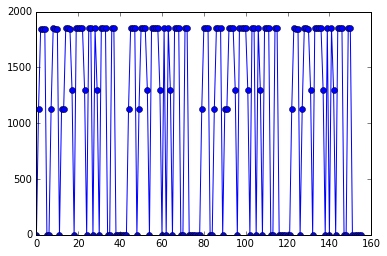

In [10]:
# get horizon forces (based on FEA so far)
aa= pd.read_csv('data/horizonFTot.csv',header=None)
aa = np.array(aa)
FG[-1,:,0] = aa[:,0] #act ID
FG[-1,:,2] = aa[:,1] #y force
FG[-1,:,3] = aa[:,2] #z force
#Yes, these y-forces only take a few discrete values. They came from Ed Hileman
# The reason is that we decided not to use the y-forces for any surface optimization.
plt.plot(aa[:,1],'-o');

In [11]:
nza = FDAA.shape[0]
dza = 90/(nza-1)
for i in range(1,nza-1):
    tp = dza*i/180*np.pi
    FG[i,:,0] = actID
    #x forces are ~6N each, due to mirror off center. FEA assumes for hirizon they are all zeros.
    #anyhow, x,y,z forces all obey sin and cos rule
    FG[i,:,1:] = FG[0,:,1:]*np.cos(tp) + FG[-1,:,1:]*np.sin(tp)

In [12]:
FBM = np.zeros(FDAA.shape)
FBM[:,:,0] = FDAA[:,:,0]
for i in range(nza):
    FBM[i,:,:] =  (fbst+fcst+fdst)/3
    FBM[i,:,:] +=  (fbbm+fcbm+fdbm)/3
FBM[:,:,0] = FBM[:,:,0]/2

In [27]:
FLUT = FG + FDAA + FBM
FLUT[:,:,0] = FLUT[:,:,0]/3
#### We have been using zenith angle as the index up to this point. We need to switch to elevation angle now.
FLUT = np.flip(FLUT, axis=0)

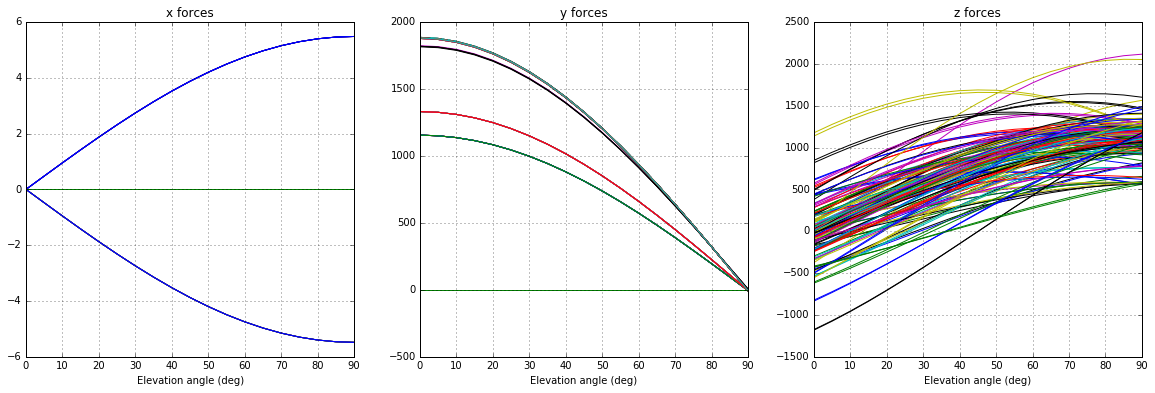

In [31]:
fig, ax = plt.subplots(1,3, figsize=(20, 6))
xx = np.linspace(0,90,nza)
a = ax[0].plot(xx,FLUT[:,:,1])
b = ax[1].plot(xx,FLUT[:,:,2])
c = ax[2].plot(xx,FLUT[:,:,3])
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_title('x forces')
ax[1].set_title('y forces')
ax[2].set_title('z forces')
ax[0].set_xlabel('Elevation angle (deg)')
ax[1].set_xlabel('Elevation angle (deg)')
ax[2].set_xlabel('Elevation angle (deg)');

In [30]:
with open('data/FLUT.yaml', "w") as yamlFile:
    yaml.safe_dump(FLUT.tolist(), stream=yamlFile, default_flow_style=None)